In [27]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
from sklearn.model_selection import train_test_split

In [28]:
import pandas as pd

# Load the dataset
df = pd.read_excel('/content/myFinalDataset(edited version).xlsx')

# Check the unique values in the 'label' column
print("Unique labels:", df['label'].unique())

# Ensure all labels are valid integers
df['label'] = pd.to_numeric(df['label'], errors='coerce')
print("Labels after coercion to numeric:", df['label'].unique())

# Drop rows with invalid labels
df = df.dropna(subset=['label'])
df['label'] = df['label'].astype(int)
print("Labels after dropping NaNs and conversion to int:", df['label'].unique())


Unique labels: [ 2.  0.  1. nan]
Labels after coercion to numeric: [ 2.  0.  1. nan]
Labels after dropping NaNs and conversion to int: [2 0 1]


In [32]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split

# Split the dataset into training and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Extract the texts and labels
train_texts = train_df['text'].tolist()
train_labels = train_df['label'].tolist()
test_texts = test_df['text'].tolist()
test_labels = test_df['label'].tolist()

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("sagorsarker/bangla-bert-base")
model = AutoModelForSequenceClassification.from_pretrained("sagorsarker/bangla-bert-base", num_labels=3)

# Tokenize the texts
def tokenize_texts(texts, labels, tokenizer, max_len=128):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels, dtype=torch.long)  # Ensure labels are of type torch.long
    return TensorDataset(input_ids, attention_masks, labels)

# Create DataLoader
train_dataset = tokenize_texts(train_texts, train_labels, tokenizer)
test_dataset = tokenize_texts(test_texts, test_labels, tokenizer)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define training parameters
epochs = 10
#optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [33]:
# Training function
def train(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)

        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs.logits
        loss_fn = torch.nn.CrossEntropyLoss()
        loss = loss_fn(logits, b_labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(dataloader)
    return avg_train_loss

# Evaluation function
def evaluate(model, dataloader, device):
    model.eval()
    preds, true_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids = b_input_ids.to(device)
            b_input_mask = b_input_mask.to(device)
            b_labels = b_labels.to(device)

            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = outputs.logits
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(b_labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, preds)
    return accuracy

# Train and evaluate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    train_loss = train(model, train_dataloader, optimizer, scheduler, device)
    test_accuracy = evaluate(model, test_dataloader, device)
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch 1/10
Train Loss: 0.8281
Test Accuracy: 0.7615
Epoch 2/10
Train Loss: 0.5018
Test Accuracy: 0.8331
Epoch 3/10
Train Loss: 0.3250
Test Accuracy: 0.8672
Epoch 4/10
Train Loss: 0.1986
Test Accuracy: 0.9030
Epoch 5/10
Train Loss: 0.1274
Test Accuracy: 0.9237
Epoch 6/10
Train Loss: 0.0849
Test Accuracy: 0.9308
Epoch 7/10
Train Loss: 0.0657
Test Accuracy: 0.9436
Epoch 8/10
Train Loss: 0.0515
Test Accuracy: 0.9459
Epoch 9/10
Train Loss: 0.0438
Test Accuracy: 0.9459
Epoch 10/10
Train Loss: 0.0395
Test Accuracy: 0.9420


In [34]:
print(f"Final Test Accuracy: {test_accuracy:.4f}")

Final Test Accuracy: 0.9420


In [35]:
from collections import defaultdict

# Evaluation function for class-wise accuracy
def evaluate_classwise(model, dataloader, device, num_classes):
    model.eval()
    class_correct = defaultdict(int)
    class_total = defaultdict(int)
    with torch.no_grad():
        for batch in dataloader:
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids = b_input_ids.to(device)
            b_input_mask = b_input_mask.to(device)
            b_labels = b_labels.to(device)

            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            for i in range(len(preds)):
                class_label = b_labels[i].item()
                class_correct[class_label] += int(preds[i] == b_labels[i])
                class_total[class_label] += 1

    class_accuracy = {class_label: class_correct[class_label] / class_total[class_label] for class_label in range(num_classes)}
    return class_accuracy

# Calculate the number of classes
num_classes = 3  # Assuming there are 3 classes

# Evaluate the model for class-wise accuracy
class_accuracy = evaluate_classwise(model, test_dataloader, device, num_classes)

# Print the final accuracy of each class
for class_label, accuracy in class_accuracy.items():
    print(f"Class {class_label} Test Accuracy: {accuracy:.4f}")


Class 0 Test Accuracy: 0.9451
Class 1 Test Accuracy: 0.9525
Class 2 Test Accuracy: 0.9262


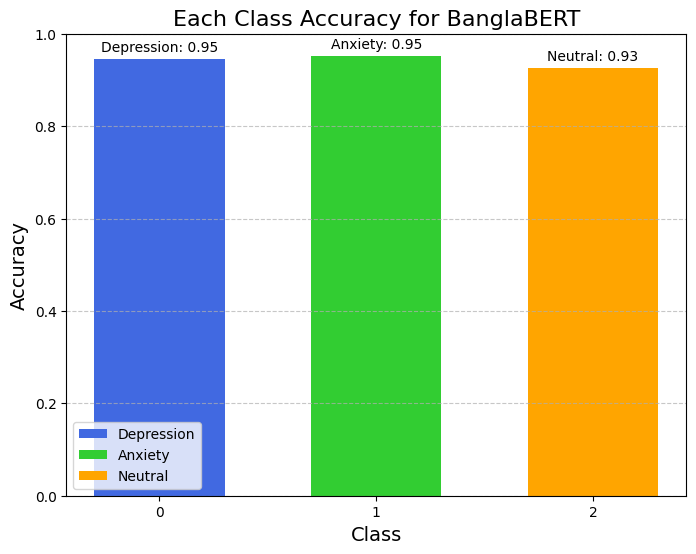

In [50]:
import matplotlib.pyplot as plt

# Class names dictionary
class_names = {0: 'Depression', 1: 'Anxiety', 2: 'Neutral'}

# Colors for each class
colors = ['royalblue', 'limegreen', 'orange']

# Evaluate the model for class-wise accuracy
class_accuracy = evaluate_classwise(model, test_dataloader, device, num_classes)

# Extract class labels and accuracies
class_labels = list(class_accuracy.keys())
accuracies = list(class_accuracy.values())

# Plot the bar graph
plt.figure(figsize=(8, 6))
bars = plt.bar(class_labels, accuracies, color=colors, width=0.6)  # Set colors for bars
plt.xlabel('Class', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Each Class Accuracy for BanglaBERT', fontsize=16)

# Add legend for the three classes
legend_labels = [class_names[label] for label in class_labels]
plt.legend(bars, legend_labels, loc='lower left')  # Place legend in lower left

# Label each bar with the class name and accuracy
for bar, label, accuracy, color in zip(bars, class_labels, accuracies, colors):
    height = bar.get_height()
    #plt.text(bar.get_x() + bar.get_width() / 2, height, class_names[label], ha='center', va='bottom', color=color)
    plt.text(bar.get_x() + bar.get_width() /2, height+0.01, f"{class_names[label]}: {accuracy:.2f}", ha='center', va='bottom', color='black')
   # plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f"{accuracy:.4f}", ha='center', va='bottom', color='black')

plt.xticks(class_labels)  # Set x-axis ticks to class labels
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
